In [151]:
#-------------------------Imports---------------------------
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from mpl_toolkits import mplot3d
#import sympy as sy #symbolic algebra
import pandas as pd
from numpy.random import random

from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy import constants

import os
#from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from tqdm import tqdm
from multiprocessing import Pool
import time

###########################
# CONSTANTS
###########################
H0GLOB= 67#67.9 #69
Om0GLOB=0.29
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later
#-------miscellanea-----------------------
xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10


print(cosmoglob)

FlatLambdaCDM(name="Planck18", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)


In [2]:
#--------------------------definitions-------------------------
def NumOfDS(x,y,z):
    #this will evaluate the dN/dz
    r=np.sqrt(x**2+y**2+z**2)
    #numberofDS=1000/r
    numberofDS=2
    num=int(numberofDS)
    #print(num)
    if num>0:
        return num
    else:
        return 1
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
#--------------Placer-----------------------------
def DS_Maker(radii,perc,numHost,xhost,yhost,zhost):
    #the DSs are generated in a sphere, centered on the host. and the distance must follow
#the correlation distribution. 
#To generate points on a unit sphere see https://mathworld.wolfram.com/SpherePointPicking.html
# A python implementation https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume
    #remember: you have to return also the indices of the hosts that have DSs
    x_Dark=[]
    y_Dark=[]
    z_Dark=[]
    phi_to_return=[]
    theta_to_return=[]
    r_to_return=[]
    full_r=[]
    
    arr_n=[]
    NDS=int(perc*numHost)
    indices=np.zeros(NDS)
    
    for k in range(NDS):
        i=np.random.randint(0, numHost-1)
        indices[k]=i
        dist_x=xhost[i]
        dist_y=yhost[i]
        dist_z=zhost[i]
        n=NumOfDS(dist_x,dist_y,dist_z)
        arr_n=np.append(arr_n,n)
        for d in range(n):
            phi =np.random.uniform(0,2*np.pi)
            costheta =np.random.uniform(-1,1)
            theta = np.arccos(costheta)
            r=np.random.choice(radii)
            full_r=np.append(full_r,r)
            if r>=distcut:
                x_DS = r * np.sin( theta) * np.cos( phi )
                y_DS = r * np.sin( theta) * np.sin( phi )
                z_DS = r * np.cos( theta )
                r_to_return=np.append(r_to_return,r)
            else:
                d=d-1

            #real values: do some check
            
            theta_to_return=np.append(theta_to_return,costheta)
            phi_to_return=np.append(phi_to_return,phi)
        
            x_Dark=np.append(x_Dark,dist_x+x_DS)
            y_Dark=np.append(y_Dark,dist_y+y_DS)
            z_Dark=np.append(z_Dark,dist_z+z_DS)
    #--------only unique indices of host-DS
    filtered=np.unique(indices.astype(int))
    return x_Dark, y_Dark, z_Dark, filtered, arr_n,r_to_return,theta_to_return,phi_to_return,full_r


In [ ]:
#----------------------Create the box & fill it with hosts-------------------
#x=np.random.normal(loc=0,scale=Sigma,size=Npoints)
#y=np.random.normal(loc=0,scale=Sigma,size=Npoints)
#z=np.random.normal(loc=0,scale=Sigma,size=Npoints)

In [ ]:
#------------read the flagship-------------------------------------
dat = Table.read('flagship.fits', format='fits')
df = dat.to_pandas()#all good, is an only text fits
print(df.columns)

In [ ]:
#distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
host_x=df['x_gal'].values/h #restore the right units
host_y=df['y_gal'].values/h
host_z=df['z_gal'].values/h
host_obs_redshift=df['observed_redshift_gal'].values
host_true_redshift=df['true_redshift_gal'].values
lum_host_x=host_x*(1+host_true_redshift)
lum_host_y=host_y*(1+host_true_redshift)
lum_host_z=host_z*(1+host_true_redshift)
dl=np.sqrt(lum_host_x[-1]**2+lum_host_y[-1]**2+lum_host_z[-1]**2)
dc=np.sqrt(host_x[-1]**2+host_y[-1]**2+host_z[-1]**2)

#print(dc,dl,dl/dc-1,host_obs_redshift[-1],host_true_redshift[-1])

In [ ]:
print(dc,dl,dl/dc-1,host_obs_redshift[-1],host_true_redshift[-1])

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
num=int(df.shape[0]*0.0001)
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           np.random.choice(lum_host_z,num), c = 'b', s = 5)
ax.set_title('Host-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('HostDist.pdf')
ax.view_init(60, 65)#rotation along x z
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.random.choice(lum_host_x,num), np.random.choice(lum_host_y,num),
           c = 'b', marker="*", label='Host')
plt.legend(loc='upper left');

In [ ]:
#----------------MC-rejection-with-CDF----------------------
r0=5*h
gamma=0.2
#rmin=0.1*h
rmin=0
distcut=0.1*h
rmax=10*h
#target function
target_dist= lambda r: (r/r0)**(gamma)
#x = sy.Symbol('x')
#norm=sy.integrate(target_dist(x), (x, rmin, rmax))
#print(norm)
values=return_samples(target_dist,rmin,rmax,1000000)
real_values=values[values>=distcut]
#shift=len(values)-len(real_values)


In [ ]:
print(len(real_values))
fast_shift=1-len(real_values)/len(values)
print(1-len(real_values)/len(values))

In [ ]:
Nhost=df.shape[0]
x_Dark, y_Dark, z_Dark, filtered,arr_n,real_r,real_theta,real_phi,full_r=DS_Maker(values,0.001,Nhost,host_x,host_y,host_z)
print(len(x_Dark))

In [ ]:
fig2 = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)
ax.set_title('DS-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('DSDist.pdf')

In [ ]:
figtot = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax1 = figtot.add_subplot(111,projection='3d')

ax1.scatter(np.take(host_x,filtered), np.take(host_y,filtered),np.take(host_z,filtered), c = 'b', marker="*", label='Host')
ax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host.pdf')

In [ ]:
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(np.take(host_x,filtered), np.take(host_y,filtered), c = 'b', marker="*", label='Host')
ax.scatter(x_Dark, y_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host_xy.pdf')

In [ ]:
'''
Some checks on what we have so far
Do To list:
1) visual proof of distributions
'''

In [ ]:
#--------------------host redshift distribution------------------------------------
n, bins, patches = plt.hist(x=host_obs_redshift, bins='auto', color='b',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('N(z)')
maxfreq = n.max()
plt.yscale('log')
plt.xscale('log')
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
## plot of the rejection results

x = np.linspace(0.1*h,rmax,1000000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,target_dist(x)/np.sum(target_dist(x)*(x[1]-x[0])) )
#ax.plot(x,target_dist(x)/norm ) #slow
ax.hist(values,bins='auto',density=True,range=(x.min(),x.max()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Two-points correlation')
plt.show() 

In [ ]:
#---------------Distribution of phi------------------
count, bins, ignored = plt.hist(real_phi, 100, density=True)
line=np.ones_like(bins)
line=line/(2*np.pi)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

In [ ]:
#---------------Distribution of cos(theta)------------------
count, bins, ignored = plt.hist(real_theta, 100, density=True)#real_theta is cos(theta)
line=np.ones_like(bins)
line=line/(2)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

In [ ]:

Npoints=100
esp=1
phi =np.random.uniform(0,2*np.pi,Npoints)
costheta =np.random.uniform(-1,1,Npoints)
theta = np.arccos(costheta)
r=np.random.choice(values,Npoints)
wire_phi = np.linspace(0, np.pi, 20)
wire_theta = np.linspace(0, 2 * np.pi, 40)
x_sph = r * np.sin( theta) * np.cos( phi )
y_sph = r * np.sin( theta) * np.sin( phi )
z_sph = r * np.cos( theta )
x = rmin*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y = rmin*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z = rmin*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
x_out = rmax*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y_out = rmax*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z_out = rmax*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
fig, ax = plt.subplots(1, 1,subplot_kw={'projection':'3d'})
fig.set_size_inches(11.5, 11.5)
ax.scatter(x_sph, y_sph , z_sph, s=20, c='k', zorder=10)
ax.scatter(0, 0 , 0, s=100, c='r', zorder=10)
#ax.plot_wireframe(x, y, z, color='b', rstride=1, cstride=1)
ax.plot_wireframe(x_out, y_out, z_out, color='g', rstride=1, cstride=1)

ax.view_init(60, 65)#rotation along x z

In [ ]:
#---------- Test using real DS data------------------------------


In [ ]:
bins = 100
counts_cdf = []
counts_new_cdf = []
r_right=[]
#r=np.random.choice(values,70000)
step = real_r.max()/bins
R_min = distcut
#new_values=values[values>=R_min]

for myi in range(bins):
    right = R_min + (myi+0)*step
    bools_old = full_r<=right
    bools_new = real_r<=right
    
    counts_cdf = np.append(counts_cdf, len(full_r[bools_old]))
    counts_new_cdf = np.append(counts_new_cdf, len(real_r[bools_new]))
    
    r_right = np.append(r_right, right)
    
    #print(counts_cdf[myi],counts_new_cdf[myi])
    #print(counts_cdf[myi]-counts_new_cdf[myi])
shift=counts_cdf[0]-counts_new_cdf[0]
#shift=0.004*len(real_r)
#shift=fast_shift*len(real_r)
counts_cdf=counts_cdf/counts_cdf.max()
counts_new_cdf=counts_new_cdf+shift
counts_new_cdf=counts_new_cdf/counts_new_cdf.max()

    
    

In [ ]:
x = np.linspace(R_min,rmax,1000000)
zeta=1.2#gamma+1
norm=(rmax**(zeta))/((zeta)*r0**gamma)
print('CDF normalization {}\t Prefactor {}'.format(norm,1/norm))
handmade_cdf=lambda x: (x**(zeta))/(rmax**(zeta))


fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

ax.plot(x,handmade_cdf(x) ,color='g')
plt.axvline(x=distcut)
ax.scatter(r_right, counts_new_cdf , s=50, marker='+', c='r', zorder=10)
ax.scatter(r_right, counts_cdf , s=20,marker='*', c='k', zorder=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

#ax.set_ylabel('probability density')

#ax.plot(x,handmade_cdf(x) ,color='g')
#plt.axvline(x=rmin)
ax.scatter(r_right, counts_cdf-counts_new_cdf , s=10,marker='x', c='r', zorder=10)#diff between full dist and dist with r_cut
ax.scatter(r_right, handmade_cdf(r_right)-counts_new_cdf , s=10,marker='x', c='g', zorder=10)#diff between cumulative and dist with r_cut
plt.axhline(y=0, color='k', linestyle='-')
#plt.ylim(bottom=-0.001,top=0.001)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('DS_cumulative.pdf')

In [ ]:
bins = 100
freq_r = []
r_center=[]
step = real_r.max()/bins
R_min = distcut
left=R_min
for myi in range(bins-1):
    right = left+ (myi+1)*step
    bools_left = left<real_r
    bools_right=real_r<=right
    bools_new= bools_left&bools_right
    #print(bools_left,bools_right,bools_new)
    freq_r = np.append(freq_r, len(real_r[bools_new]))
    
    r_center = np.append(r_center, left+step/2)
    left=right

In [ ]:
count= plt.hist(real_r, 100)#real_theta is cos(theta)

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')

xx=count[1]
xx=xx[:-1]
yy=count[0]
print(np.all(yy>20))
yy_err=np.sqrt(yy)/yy.sum()
yy=yy/yy.sum()

arr_teo=target_dist(xx)
arr_teo=arr_teo/arr_teo.sum()
res=yy-arr_teo
res2=(yy-arr_teo)/yy_err
ax.scatter(xx,res , s=10,marker='x', c='b', zorder=10)
plt.axhline(y=0, color='k', linestyle='-')
plt.errorbar(xx, res, yerr=yy_err, fmt="+")

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
#plt.yscale('log')
#plt.xscale('log')



In [ ]:

fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(xx,res2 , s=10,marker='x', c='k', zorder=10)
ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Distance in sigma')
#plt.yscale('log')
#plt.xscale('log')


In [ ]:
mu=res2.mean()


In [ ]:
#--------------------SDSS like-------------------------
num_of_gal=np.array([1300,1300,500,800,800,1500,650,100,20,10])#Number of hosts in each z bin. 
sdss_bins=np.linspace(0,1,11)#bin Width 
#---------------Angular part--------------------------------
#we need to cover only 30 squared degrees of sky. phi = U(0,phi_lim) cos_theta=U(1,cos_lim)
#1 sq.deg.=(np.pi/180)**2 sr 

In [ ]:
alpha=30*(np.pi/180)**2
phi_lim=(2*np.pi-alpha/2)/24#In this way phi_lim ~ theta_lim 
theta_lim=np.arccos(1-alpha/phi_lim)
#print(phi_lim,theta_lim)
all_phi=np.random.uniform(0,phi_lim,500000)
all_cos=np.random.uniform(1,1-alpha/phi_lim,500000)
print(phi_lim,theta_lim)

In [ ]:
sdss_cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
sdss_lum=[]
sdss_phi=[]
sdss_cos_theta=[]
sdss_redshift=[]

for i in range(len(num_of_gal)):
    for k in range(num_of_gal[i]):
        sdss_phi=np.append(sdss_phi,np.random.choice(all_phi))
        sdss_cos_theta=np.append(sdss_cos_theta,np.random.choice(all_cos))
        z=np.random.uniform(0.1*i,0.1*(i+1))
        sdss_redshift=np.append(sdss_redshift,z)
        dl=(1+z)*sdss_cosmo.comoving_distance(z).value
        sdss_lum=np.append(sdss_lum,dl)
#In a flat Universe we have
sdss_x=sdss_lum*np.sin(np.arccos(sdss_cos_theta))*np.cos(sdss_phi)
sdss_y=sdss_lum*np.sin(np.arccos(sdss_cos_theta))*np.sin(sdss_phi)
sdss_z=sdss_lum*sdss_cos_theta

    

In [ ]:
zz=np.linspace(0,1,5000)
distinterpol=(1+zz)*sdss_cosmo.comoving_distance(zz).value
z_of_dl=interpolate.interp1d(distinterpol,zz)
#data from https://dcc.ligo.org/LIGO-T1800044/public
freq=np.loadtxt('ALIGO_sens.txt',usecols=0)
noise=np.loadtxt('ALIGO_sens.txt',usecols=1)#This is the amplitude so must be squared
Aligo_sn=interpolate.interp1d(freq,noise)
max_noise=noise.max()
norm_noise=noise/max_noise
Aligo_sn_norm=interpolate.interp1d(freq,norm_noise)

In [ ]:
#------------W(D) of arxiv 1804.06085-------------------
#evaluate the antenna function F+ & Fx and h+ & hx
m1=10#Solar Mass units
m2=10
m1=m1*solarmass_to_m
m2=m2*solarmass_to_m

M=m1+m2
eta=(m1*m2)/(M**2)
M_c=M*eta**(3/5)#This mass must be redshifted
prefactor=np.sqrt((5/24))*((np.pi)**(-2/3))
cos_inclination=np.linspace(-1,1,100)
dist_min=50
dist_max=3500
n_bins=int((dist_max-dist_min)/100)
distances=np.linspace(dist_min,dist_max,n_bins)
n_BBH=1600
arr_phi=np.random.uniform(0,2*np.pi,500000)
arr_cos=np.random.uniform(1,-1,500000)
arr_psi=np.random.uniform(0,2*np.pi,500000)

mydist=[50,100,250,500,1000,1500,2000,2500,3000,3500]
print(solarmass_to_m,Mpc_to_m)
print('G={},   c={}'.format(constants.G,constants.c))

#--------analitic noise from paper
s0=3.2*10**(-46)
f0=500

In [ ]:
#The integral can be performed with [dl]=s and [M_c]=s or [dl]=m and [M_c]=m and [f]=m
def hplus_new(f,constant,mass,dist,z,cos):
    dist=dist*Mpc_to_m
    dist=dist/constants.c
    mass=mass/constants.c
    #x=f/constants.c
    numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    #denom=Aligo_sn(f)
    #denom=(constants.c**2)*(Aligo_sn(f)**2)#We need the noise power spectra
    denom=(Aligo_sn(f)**2)
    #denom=noise_analitic(f)
    return (numerator/denom) 

def hcross_new(f,constant,mass,dist,z,cos):
    dist=dist*Mpc_to_m
    dist=dist/constants.c
    mass=mass/constants.c
    #x=f/constants.c
    numerator=((constant/dist)*(mass**(5/6))*(cos**2)*f**(-7/6))**2
    #denom=Aligo_sn(f)
    #denom=(constants.c**2)*(Aligo_sn(f)**2) #We need the noise power spectra
    denom=(Aligo_sn(f)**2)
    #denom=noise_analitic(f)
    return (numerator/denom)
#noise analitic->noise virgo 
def noise_analitic(f):
    #ret=(((f/f0)**(-4.14))-5*((f/f0)**(-2))+(111*(1-(f/f0)**2)+0.5*(f/f0)**4)/(1+0.5*(f/f0)**2))*s0
    n1=(7.8*f/f0)**(-5)
    n2=2*((f/f0)**(-1))
    n3=0.63
    n4=(f/f0)**2
    ret=s0*(n1+n2+n3+n4)
    return ret

def angular_power(cos_theta,phi):
    ret=0.25*((1+cos_theta**2)**2)*(np.cos(2*phi))**2+((cos_theta**2)*((np.sin(2*phi))**2))
    return ret
def antenna_response(ds_cos_theta,ds_phi,ds_psi):
    cos_theta=np.random.choice(ds_cos_theta)
    phi=np.random.choice(ds_phi)
    psi=np.random.choice(ds_psi)
    A=0.5*(1+cos_theta**2)*(np.cos(2*phi))
    B=cos_theta*(np.sin(2*phi))
    fplus=A*(np.cos(2*psi))-B*(np.sin(2*psi))
    fcross=A*(np.sin(2*psi))-B*(np.cos(2*psi))
    ret=fplus**2 + fcross**2
    return ret

def full_integrand(f,constant,mass,dist,cos_i,ds_cos_theta,ds_phi,ds_psi):
    dist=dist*Mpc_to_m
    cos_theta=np.random.choice(ds_cos_theta)
    phi=np.random.choice(ds_phi)
    psi=np.random.choice(ds_psi)
    A=0.5*(1+cos_theta**2)*(np.cos(2*phi))
    B=cos_theta*(np.sin(2*phi))
    fplus=A*(np.cos(2*psi))-B*(np.sin(2*psi))
    fcross=A*(np.sin(2*psi))-B*(np.cos(2*psi))
    hplus_squared=((constant/dist)*(mass**(5/6))*(((1+cos_i**2)/2)**2)*f**(-7/6))**2
    hcross_squared=((constant/dist)*(mass**(5/6))*(cos_i**2)*f**(-7/6))**2
    numerator=hplus_squared*(fplus**2)+hcross_squared*(fcross**2)
    denom=Aligo_sn(f)**2
    return (numerator/denom)
    

In [ ]:
freq_for_plot=np.linspace(freq.min(),freq.max(),100000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('S_n (1/Hz)')
ax.plot(freq_for_plot,noise_analitic(freq_for_plot),label='Virgo analitic noise')
ax.plot(freq_for_plot,Aligo_sn(freq_for_plot)**2/freq_for_plot,label='LIGO noise')
plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

In [ ]:
dl=4000
z_ds=z_of_dl(dl)
red_Mc=M_c*(1+z_ds)
cos_i=1 #np.random.choice(cos_inclination)
start_time = time.time()
temp_plus=quad(hplus_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
temp_cross=quad(hcross_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
detector_prefactor=antenna_response(arr_cos,arr_phi,arr_psi)
SNR=np.sqrt((temp_plus+temp_cross)*detector_prefactor*4)

#pow_factor=angular_power()
#we are interested in the angular mean so we can mediate over theta and phi. The results is 0.97712
print(SNR,temp_plus,temp_cross)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
mean_angular_power=0.97712

def weights(dist_ds):
    n_iteration=len(dist_ds)
    detected=np.zeros(n_iteration)
    for k in tqdm(range(n_iteration),desc='Progress'):
        for i in range(n_BBH):
            dl=np.random.uniform(dist_ds[k],dist_ds[k]+10)
            z_ds=z_of_dl(dl)
            red_Mc=M_c*(1+z_ds)
            cos_i=np.random.choice(cos_inclination)
            temp_plus=quad(hplus_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
            temp_cross=quad(hcross_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
            SNR=2*np.sqrt((temp_plus+temp_cross)*mean_angular_power)
            #integral=quad(full_integrand,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,cos_i,arr_cos,arr_phi,arr_psi))[0]
            #SNR=np.sqrt((integral)*4)
            if SNR >= 8:
                detected[k]=detected[k]+1
    return detected

In [ ]:
#arr_cos=np.ones(100)
#arr_phi=np.zeros(100)

In [ ]:
mean_angular_power=0.97712

def weights_multi(dist_ds):
    det=0
    for i in range(n_BBH):
        dl=np.random.uniform(dist_ds,dist_ds+10)
        z_ds=z_of_dl(dl)
        red_Mc=M_c*(1+z_ds)
        cos_i=np.random.choice(cos_inclination)
        temp_plus=quad(hplus_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        temp_cross=quad(hcross_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        detector_prefactor=antenna_response(all_cos,all_phi,arr_psi)
        SNR=np.sqrt((temp_plus+temp_cross)*detector_prefactor*4)
        #integral=quad(full_integrand,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,cos_i,arr_cos,arr_phi,arr_psi))[0]
        #SNR=np.sqrt((integral)*4)
        if SNR >= 8:
            det=det+1
    return det

In [ ]:
start_time = time.time()
short_dist=np.linspace(50,750,25)
with Pool(20) as p:
    detected=p.map(weights_multi, distances)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
arr1=np.array(detected)
arr1=100*arr1/n_BBH
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr1 , s=10, c='g', zorder=10)
#ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
#plt.xscale('log')

In [ ]:
#network antenna from: Networks of gravitational wave detectors and three figures of merit
#we have to set a global reference frame and evaluate f_+ and f_x for each detector
#having care to rotate each S.o.R.
def A_factor(xi,beta,lamb,theta,phi):
    a1=(1/16)*np.cos(2*xi)*(3-np.cos(2*beta))*(3-np.cos(2*theta))*np.cos(2*(phi+lamb))
    a2=0.25*np.cos(2*xi)*np.sin(beta)*(3-np.cos(2*theta))*np.sin(2*(phi+lamb))
    a3=0.25*np.sin(2*xi)*np.sin(2*beta)*np.sin(2*theta)*np.cos(phi+lamb)
    a4=0.5*np.cos(2*xi)*np.cos(beta)*np.sin(2*theta)*np.sin(phi+lamb)
    a5=(3/4)*np.sin(2*xi)*(np.cos(beta)**2)*(np.sin(theta)**2)
    ret=a1+a2+a3+a4+a5
    return ret
def B_factor(xi,beta,lamb,theta,phi):
    b1=np.cos(2*xi)*np.sin(beta)*np.cos(theta)*np.cos(2*(phi+lamb))
    b2=0.25*np.sin(2*xi)*(3-np.cos(2*beta))*np.cos(theta)*np.sin(2*(phi+lamb))
    b3=np.cos(2*xi)*np.cos(beta)*np.sin(theta)*np.cos(phi+lamb)
    b4=0.5*np.sin(2*xi)*np.sin(2*beta)*np.sin(theta)*np.sin(phi+lamb)
    ret=b1-b2+b3-b4
    return ret
def antenna_pattern(xi,beta,lamb,theta,phi,psi):
    fplus=A_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)+B_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fcross=B_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)-A_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fplus_squared=fplus**2
    fcross_squared=fcross**2
    ret=fplus_squared+fcross_squared
    return ret


In [ ]:
#xi,beta,lamb for each detector
def rad_from_deg(angle):
    if angle<0:
        convert=360+angle #angle is negative
    else:
        convert=angle
    ret=convert*np.pi/180
    return ret
#gamma, lambda, L of other paper
Ligo_H=np.array([rad_from_deg(171.8),rad_from_deg(46.45),rad_from_deg(119.41)])
Ligo_L=np.array([rad_from_deg(243),rad_from_deg(30.56),rad_from_deg(90.77)])
Virgo=np.array([rad_from_deg(116.5),rad_from_deg(43.63),rad_from_deg(-10.5)])


In [ ]:
freq_for_plot=np.linspace(freq.min(),freq.max(),100000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('Integrand (1/Hz)')
plotdl=1000
zplot=z_of_dl(plotdl)
red_Mc=M_c*(1+zplot)
#ax.plot(freq_for_plot,noise_analitic(freq_for_plot),label='Virgo analitic noise')
ax.plot(freq_for_plot,((hplus_new(freq_for_plot,prefactor,red_Mc,plotdl,zplot,1))**2 +(hcross_new(freq_for_plot,prefactor,red_Mc,plotdl,zplot,1))**2)/(Aligo_sn(freq_for_plot)**2),label='LIGO noise')

plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

In [ ]:
def network_angular_response(dist_ds):
    det=0
    flag=0
    det_h=0
    det_l=0
    det_v=0
    for i in range(n_BBH):
        dl=dist_ds#np.random.uniform(dist_ds,dist_ds+1)
        z_ds=z_of_dl(dl)
        red_Mc=M_c*(1+z_ds)
        cos_i=np.random.choice(cos_inclination)
        temp_plus=quad(hplus_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        temp_cross=quad(hcross_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        ds_phi=np.random.choice(arr_phi)
        ds_theta=np.arccos(np.random.choice(arr_cos))
        ds_psi=np.random.choice(arr_psi)
        hanford_prefactor=antenna_pattern(Ligo_H[0],Ligo_H[1],Ligo_H[2],ds_theta,ds_phi,ds_psi)
        SNR_quad_hanford=(temp_plus+temp_cross)*hanford_prefactor*4
        #integral=quad(full_integrand,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,cos_i,arr_cos,arr_phi,arr_psi))[0]
        #SNR=np.sqrt((integral)*4)
        if SNR_quad_hanford>= 8*8:
            flag=flag+1
            det_h=det_h+1
        livingstone_prefactor=antenna_pattern(Ligo_L[0],Ligo_L[1],Ligo_L[2],ds_theta,ds_phi,ds_psi)
        SNR_quad_livingstone=(temp_plus+temp_cross)*livingstone_prefactor*4
        if SNR_quad_livingstone>= 8*8:
            flag=flag+1
            det_l=det_l+1
        virgo_prefactor=antenna_pattern(Virgo[0],Virgo[1],Virgo[2],ds_theta,ds_phi,ds_psi)
        SNR_quad_virgo=(temp_plus+temp_cross)*virgo_prefactor*4
        if SNR_quad_virgo>= 8*8:
            flag=flag+1
            det_v=det_v+1
        network_soglia=np.sqrt((SNR_quad_hanford+SNR_quad_livingstone+SNR_quad_virgo)/3)
        if ((flag>=2) and (network_soglia>=8)):
        #if (flag>=2):
            det=det+1
        flag=0
    return det,det_h,det_l,det_v

In [ ]:
test_dist=np.linspace(50,750,10)
start_time = time.time()
with Pool(35) as p:
    all_results=p.map(network_angular_response, distances)
print("--- %s seconds ---" % (time.time() - start_time))
all_results=np.array(all_results)
detected_multi=all_results[::,0]
hanford=all_results[::,1]
livingstone=all_results[::,2]
virgo=all_results[::,3]

In [ ]:
arr=np.array(detected_multi)
hanford=np.array(hanford)
livingstone=np.array(livingstone)
virgo=np.array(virgo)

arr=100*arr/n_BBH
hanford=100*hanford/n_BBH
livingstone=100*livingstone/n_BBH
virgo=100*virgo/n_BBH

fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr , s=10, c='g', zorder=10)
#ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
#plt.xscale('log')

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr , s=10, c='g', zorder=10,label='total')
#ax.scatter(distances,arr1 , s=10, c='b', zorder=10)
ax.scatter(distances,hanford , s=10, c='k', zorder=10,label='Hanford')
ax.scatter(distances,livingstone , s=10, c='r', zorder=10,label='Livingstone')
ax.scatter(distances,virgo , s=10, c='m', zorder=10,label='Virgo')
#ax.fill_between(distances,arr,arr1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
plt.legend()
plt.xscale('log')
#plt.savefig('MC_Weights_AllSky.pdf')

In [ ]:
#--------------------GW--Rate-----------------------------------------
#We will compute the gw rate from sratch 
#print(th)

In [152]:
#--------Star Formation Rate-------------------------------
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
th=1000/cosmoglob.H(0).value
alpha=14/th
def psi(x):
    ret= 0.015*(((1+x)**(2.7))/(1+(((1+x)/(2.9))**(5.6))))
    return ret
#-------------Phi----------------------------
#phi=lambda x:(1/((1+x)*(cosmofast.H(x).value)))
def phi(x):
    N=14/((1/((1+0)*(cosmoglob.H(0).value))))
    ret=N*(1/((1+x)*(cosmoglob.H(x).value)))
    return ret
def psiphi(x):
    ret=psi(x)*phi(x)
    return ret
def massrestore(x,z):
    ret=1/(1+(x-z))
    #ret=(1+(x-z))#/(1+x)
    return ret
#--------------time difference-------------------------
def inversetimediff(x,z,tmin):
    timediff=alpha*(cosmoglob.age(z).value-cosmoglob.age(x).value)
    num=np.heaviside((alpha*cosmoglob.age(z).value-alpha*cosmoglob.age(x).value) -tmin,0.5)
    before=np.heaviside(-(cosmoglob.age(z).value-cosmoglob.age(x).value -tmin),0.5)
    #res=before+(num*tmin)/timediff
    res=(num)/timediff
    return res
#------------------integrand------------------------------
def integrand(x,z,tmin):
    ret=psi(x)*(phi(x))*inversetimediff(x,z,tmin)#*massrestore(x,z)
    return ret

In [ ]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('SFR')
ax.plot(z_for_plot,psi(z_for_plot),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [ ]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('Phi')
ax.plot(z_for_plot,phi(z_for_plot),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [ ]:
z_for_plot=np.linspace(0,10,1000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('SFR')
ax.plot(z_for_plot,inversetimediff(z_for_plot,4,0.2),label='Mandau SFR')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [143]:
z_min=0
z_max=z_min+100
tpar=0.1
#--------Normalization (z=0,N*R(z=0)=25)----------------------------
Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tpar))[0]
#print(Normaliz)
#-------------loop for the plot------------------------------------
z_plot_max=10
ZZ=np.linspace(z_min,z_plot_max,33)
ratetoplot=np.zeros(len(ZZ))
for i in range(len(ZZ)):
    #Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tstart))[0]
    ratetoplot[i]=Normaliz*quad(integrand,ZZ[i],ZZ[i]+100,args=(ZZ[i],tpar))[0]
z_min=0
z_max=z_min+100
tpar=2
#--------Normalization (z=0,N*R(z=0)=25)----------------------------
Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tpar))[0]
#print(Normaliz)
#-------------loop for the plot------------------------------------
z_plot_max=10
ZZ=np.linspace(z_min,z_plot_max,33)
ratetoplot01=np.zeros(len(ZZ))
for i in range(len(ZZ)):
    #Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tstart))[0]
    ratetoplot01[i]=Normaliz*quad(integrand,ZZ[i],ZZ[i]+100,args=(ZZ[i],tpar))[0]

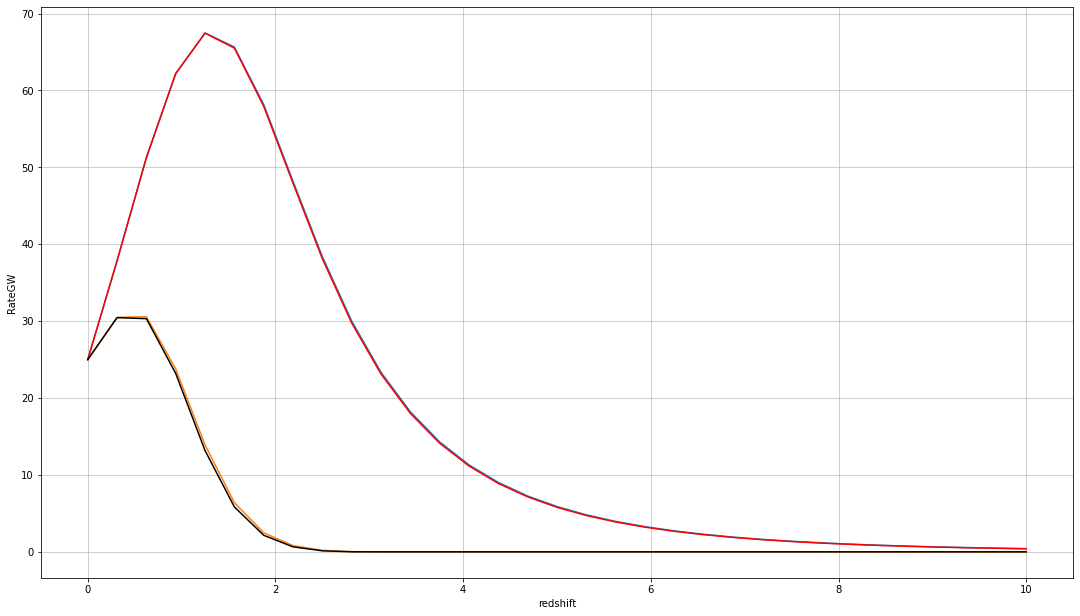

In [144]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('RateGW')
#test=ratetoplot
#test01=ratetoplot01
ax.plot(ZZ,ratetoplot,label='RateGW')
ax.plot(ZZ,ratetoplot01,label='RateGW')
ax.plot(ZZ,test,label='RateGW',color='r')
ax.plot(ZZ,test01,label='RateGW',color='k')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)

In [153]:
z_min=0
z_max=z_min+100
tstart=np.array([0.1,0.5,2,3,5,7,10])
#tstart=np.array([0.1,0.5,2,10])
#--------Normalization (z=0,N*R(z=0)=25)----------------------------
#Normaliz=25/quad(integrand,z_min,z_max,args=(z_min,tstart))[0]
#print(Normaliz)
#-------------loop for the plot------------------------------------
z_plot_max=10
Z=np.linspace(z_min,z_plot_max,100)
#ratetoplot=np.zeros(len(Z))
allrates=np.zeros((len(tstart),len(Z)))
for k in tqdm(range(len(tstart)),desc='Progress'):
    t=tstart[k]
    Normaliz=25/(quad(integrand,0,z_max,args=(0,t))[0])
    for i in range(len(Z)):
        allrates[k,i]=Normaliz*(quad(integrand,Z[i],Z[i]+100,args=(Z[i],t))[0])

Progress: 100%|██████████| 4/4 [03:35<00:00, 53.75s/it] 


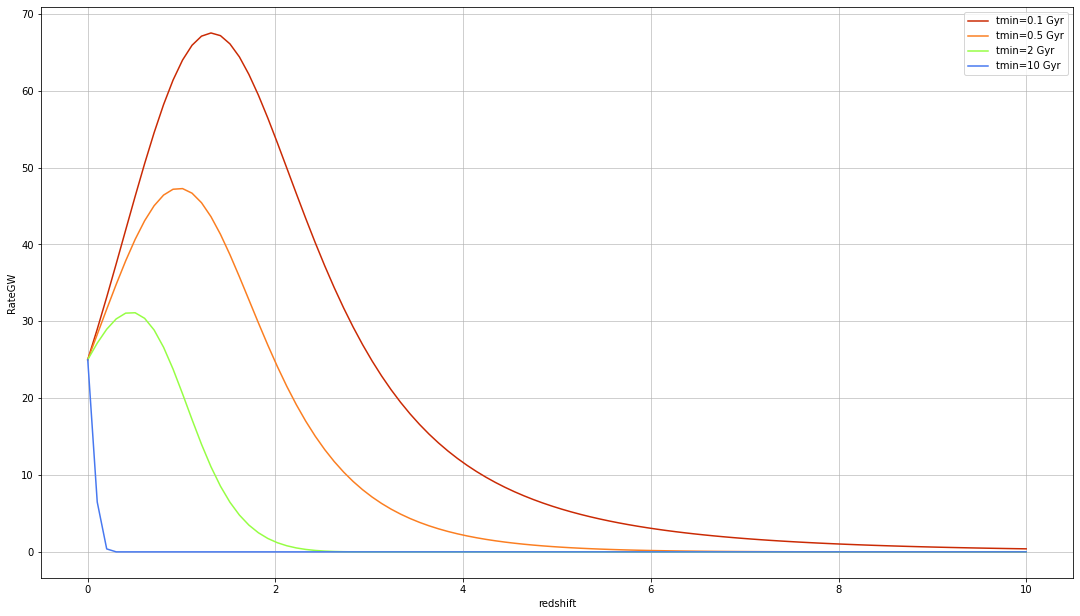

In [158]:
colors=pl.cm.turbo(np.linspace(0.99,0.01,30))
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('redshift')
ax.set_ylabel('RateGW')
ax.plot(Z,allrates[0],label='tmin=0.1 Gyr',color=colors[3])
ax.plot(Z,allrates[1],label='tmin=0.5 Gyr',color=colors[7])
ax.plot(Z,allrates[2],label='tmin=2 Gyr',color=colors[15])
#ax.plot(Z,allrates[3],label='tmin=3 Gyr',color=colors[9])
#ax.plot(Z,allrates[4],label='tmin=5 Gyr',color=colors[12])
#ax.plot(Z,allrates[5],label='tmin=7 Gyr',color=colors[15])
ax.plot(Z,allrates[6],label='tmin=10 Gyr',color=colors[25])
#ax.plot(Z,ratetoplot01,label='RateGW')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()
#plt.savefig('Rates.pdf')

<Figure size 432x288 with 0 Axes>